In [1]:
import json
import math
import os
from pathlib import Path

import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import extension as ext
from extension import ops_3d, Mesh, utils
from segmentation.networks.SemanticSAM import SemanticSAM, semantic_sam_l
from segmentation.tree_segmentation import TreeStructure, TreeData, MaskData, Tree3Dv2, Tree3D, TreePredictor, \
    TreeSegmentMetric
from segmentation.tree_segmentation.util import show_masks, show_all_levels

2023-07-26 08:46:21.981477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 08:46:23.084538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-07-26 08:46:23.084682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
glctx = dr.RasterizeCudaContext()
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

Data Root: /home/wan/data/PartNet/data_v0
There are 32537 shapes


In [5]:
# example = data_root.joinpath('12012')
example = data_root.joinpath('22835')
# example = data_root.joinpath('27774')
print(f"Example dir", example)
cache_dir = cache_root.joinpath(hashlib.md5(str(example.joinpath('objs').resolve()).encode()).hexdigest())
cache_dir.mkdir(exist_ok=True)
print('Cache Dir:', cache_dir)
with example.joinpath('meta.json').open('r') as f:
    meta = json.load(f)
print('meta:', meta)
with example.joinpath('result_after_merging.json').open('r') as f:
    meta_parts = json.load(f)
print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))

Example dir /home/wan/data/PartNet/data_v0/22835
Cache Dir: /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28
meta: {'model_id': '5554b586330150ab6d5ac6b606b81bbd', 'anno_id': '22835', 'user_id': 'yz_zhangcong', 'time_in_sec': '910', 'version': '2', 'model_cat': 'Table'}
[<DirEntry 'parts_render'>, <DirEntry 'parts_render_after_merging'>, <DirEntry 'result.json'>, <DirEntry 'tree_hier.html'>, <DirEntry 'objs-normalized-as-shapenetv1'>, <DirEntry 'result_after_merging.json'>, <DirEntry 'objs'>, <DirEntry 'tree_hier_after_merging.html'>, <DirEntry 'meta.json'>, <DirEntry 'point_sample'>]


In [6]:
# Load Mesh
part_paths = sorted(list(example.joinpath('objs').glob('*.obj')))
part_names = [part_path.stem for part_path in part_paths]
print(part_names)
part_meshes = [Mesh.load(part_path, mtl=False) for part_path in sorted(part_paths)]
print(f"There are {len(part_meshes)} parts", part_meshes[0])

for part in part_meshes:
    assert 0 <= part.f_pos.min() and part.f_pos.max() < len(part.v_pos)
mesh = Mesh.merge(*part_meshes)
mesh = mesh.cuda().unit_size()

part_map = torch.zeros(mesh.f_pos.shape[0] + 1, device=device, dtype=torch.int)
num = 1
for part_idx, part in enumerate(part_meshes, 1):
    part_map[num:num + part.f_pos.shape[0]] = part_idx
    num += part.f_pos.shape[0]
print(mesh)
print(part_map.shape, part_map.unique())

['new-0', 'new-1', 'new-2', 'new-3', 'new-4', 'original-1', 'original-2', 'original-3', 'original-4', 'original-5', 'original-6', 'original-7', 'original-9']
There are 13 parts Mesh(vertices=15182, faces=213)
Mesh(vertices=75979, faces=30568)
torch.Size([30569]) tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       device='cuda:0', dtype=torch.int32)


In [7]:
# build gt Tree
gt = Tree3D(mesh, device=device)
show_tree = Tree(f"{meta_parts[0]['name']}_{meta_parts[0]['id']}")


def get_ground_truth(data, gt_tree: Tree3D, tree: Tree, node=0):
    added_leaf = np.zeros(len(part_names), dtype=bool)

    if 'children' in data:
        for child in data['children']:
            child_node = gt_tree.node_new()
            tree_i = tree.add(f"{child['name']}_{child['id']}")
            gt_tree.node_insert(child_node, node)
            added_leaf |= get_ground_truth(child, gt_tree, tree_i, child_node)

    for part_name in data['objs']:
        part_idx = part_names.index(part_name) + 1
        if added_leaf[part_idx - 1]:
            continue
        added_leaf[part_idx - 1] = True
        if 'children' in data or len(data['objs']) > 1:
            leaf = gt_tree.node_new()
            gt_tree.node_insert(leaf, node)
        else:
            leaf = node
        gt_tree.face_parent[part_map == part_idx] = leaf
        tree.add(f"[red]{part_name}")
    # remove chain
    if len(gt_tree.get_children(node)) == 1:
        if node == 0:
            gt_tree.node_delete(gt_tree.first[node].item(), move_children=Tree)
        else:
            gt_tree.node_delete(node, move_children=True)
    return added_leaf


part_map = part_map.to(device)
assert len(meta_parts) == 1
get_ground_truth(meta_parts[0], gt, show_tree)
console.print(show_tree)
gt.print_tree()
part_map = part_map.cpu()

[Tree] reset
[Tree] Resize tree from 1 to 11
[Tree] Resize tree from 11 to 21
[Tree] Resize tree from 21 to 31


table_0
└── regular_table_1
    ├── tabletop_2
    │   └── tabletop_surface_3
    │       └── board_4
    │           └── original-1
    └── drawer_base_5
        ├── drawer_6
        │   ├── drawer_box_7
        │   │   └── drawer_front_8
        │   │       └── new-3
        │   └── handle_9
        │       └── new-1
        ├── drawer_10
        │   ├── drawer_box_11
        │   │   └── drawer_front_12
        │   │       └── new-2
        │   └── handle_13
        │       └── new-0
        ├── back_panel_14
        │   └── original-9
        ├── vertical_side_panel_15
        │   └── original-7
        ├── vertical_side_panel_16
        │   └── original-6
        ├── vertical_front_panel_17
        │   └── new-4
        ├── leg_18
        │   └── original-5
        ├── leg_19
        │   └── original-4
        ├── leg_20
        │   └── original-3
        └── leg_21
            └── original-2

0: Tree Root
├── 4
└── 5
    ├── 21
    ├── 20
    ├── 19
    ├── 18
    ├── 17
    ├── 16
    ├── 15
    ├── 14
    ├── 10
    │   ├── 13
    │   └── 12
    └── 6
        ├── 9
        └── 8

In [8]:
gt_v2 = Tree3Dv2.convert(gt)
gt_v2.print_tree()
gt_v2.save(cache_dir.joinpath('gt.tree3dv2'))

[Tree] reset
[Tree] reset
[Tree] Resize tree from 1 to 21
[Tree] rerange nodes


0: Tree Root
├── 1
└── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    ├── 9
    ├── 10
    ├── 11
    │   ├── 13
    │   └── 14
    └── 12
        ├── 15
        └── 16

[Tree3D] Save results to /home/wan/wan_code/segmentation/tree_segmentation/results/1b44f4e4724b07e54df71eef5e7f6d28/gt.tree3dv2


In [9]:
@torch.no_grad()
def render_mesh(mesh, image_size=256, num=1, num_split=10):
    fovy = math.radians(60)
    Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
    radius = torch.rand((num,), device=device) * 0.1 + 2.5
    thetas = torch.arccos(torch.rand((num,), device=device) * 2. - 1.)
    phis = torch.rand((num,), device=device) * 2.0 * torch.pi
    # thetas = torch.tensor([90.], device=device).deg2rad_()
    # phis = torch.ones((num,), device=device) * 0.5 * torch.pi
    eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
    Tw2v = ops_3d.look_at(eye, torch.zeros_like(eye))
    Tv2w = ops_3d.look_at(eye, torch.zeros_like(eye), inv=True)
    Tw2c = Tv2c @ Tw2v

    images = []
    tri_ids = []
    for s in range(0, num, num_split):
        e = min(s + num_split, num)
        v_pos = ops_3d.xfm(mesh.v_pos, Tw2c[s:e])
        # assert v_pos.ndim == 3
        rast, _ = dr.rasterize(glctx, v_pos, mesh.f_pos.int(), (image_size, image_size))
        view_pos = Tv2w[s:e, None, None, :3, 3]
        # nrm = ops_3d.compute_shading_normal(mesh,view_pos, rast, None)
        nrm = ops_3d.compute_shading_normal_face(mesh, view_pos, rast)
        view_dir = ops_3d.normalize(view_pos)
        light = ops_3d.normalize(view_dir + torch.randn(3, device=device) * 0.01)
        img = ops_3d.Blinn_Phong(
            nrm, light, view_dir, (nrm.new_full((3,), 0.2), nrm.new_full((3,), 0.5), nrm.new_full((3,), 0.1))
        ).clamp(0, 1)
        img = dr.antialias(img, rast, v_pos, mesh.f_pos.int())
        images.append(img)
        # tri_ids.append(part_map[rast[..., -1].long()])
        tri_ids.append(rast[..., -1].long())
    images, tri_ids = torch.cat(images, dim=0), torch.cat(tri_ids, dim=0)
    mask = tri_ids[..., None] > 0
    images = torch.where(mask, images, torch.ones_like(images))  # white backbground
    images = torch.cat([images, mask.to(images)], dim=-1)
    return images, tri_ids, Tw2v

F32Tensor[100, 1024, 1024, 4], LongTensor[100, 1024, 1024], F32Tensor[100, 4, 4]


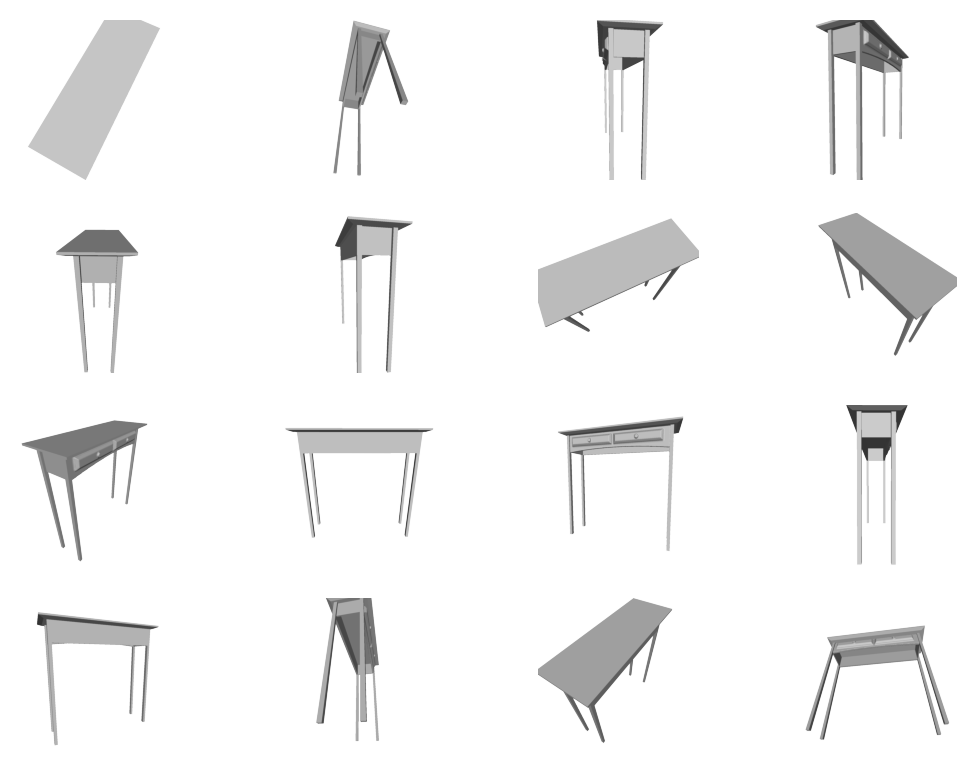

In [10]:
num_views = 100
torch.manual_seed(42)
images, tri_ids, Tw2vs = render_mesh(mesh.to(device), image_size=1024, num=num_views)
images, tri_ids, Tw2vs = images.cpu(), tri_ids.cpu(), Tw2vs.cpu()
print(utils.show_shape(images, tri_ids, Tw2vs))
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

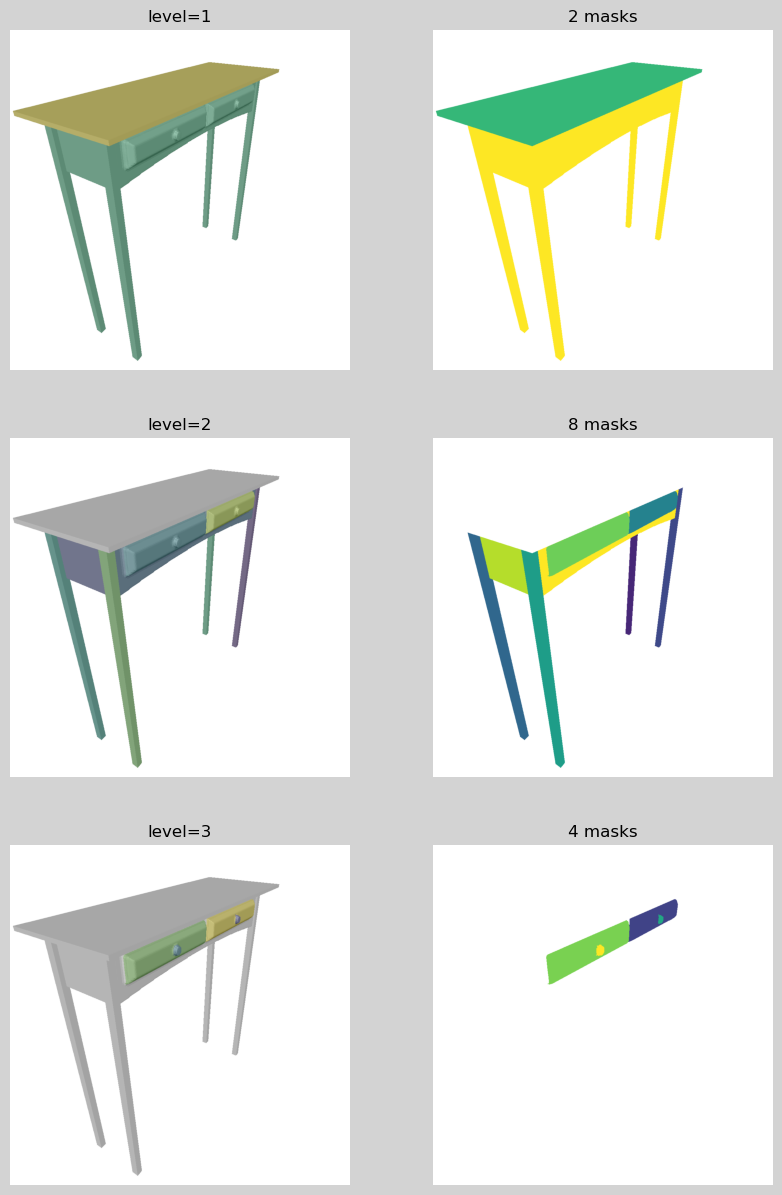

In [11]:
show_index = 8
num_level = show_all_levels(images[show_index, :, :, :3], gt, tri_ids[show_index], facecolor='lightgray')
plt.show()

In [12]:
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
print(model)
predictor = TreePredictor(model)

/home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Do not load pretrained models
SemanticSAM(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(patch_size=(4, 4), embed_dim=192, flatten=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        SwinTransformerBlock(dim=192, num_heads=6, mlp_ratio=4.0, window_size=12) * 2
        PatchMerging(dim=192)
      )
      (1): BasicLayer(
        SwinTransformerBlock(dim=384, num_heads=12, mlp_ratio=4.0, window_size=12) * 2
        PatchMerging(dim=384)
      )
      (2): BasicLayer(
        SwinTransformerBlock(dim=768, num_heads=24, mlp_ratio=4.0, window_size=12) * 18
        PatchMerging(dim=768)
      )
      (3): BasicLayer(SwinTransformerBlock(dim=1536, num_heads=48, mlp_ratio=4.0, window_size=12) * 2)
    )
    (norm_4): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (norm_8): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm_16): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm_32): Lay

image: F32Tensor[1024, 1024, 3]
complete init segmentation
complete iter 0 update segmentation
complete iter 1 update segmentation
complete iter 2 update segmentation
complete iter 3 update segmentation
complete iter 4 update segmentation
complete iter 5 update segmentation
complete iter 6 update segmentation
complete iter 7 update segmentation
complete iter 8 update segmentation
complete iter 9 update segmentation
complete iter 10 update segmentation
complete iter 11 update segmentation
complete iter 12 update segmentation
complete iter 13 update segmentation
complete iter 14 update segmentation
complete iter 15 update segmentation
complete iter 16 update segmentation


5

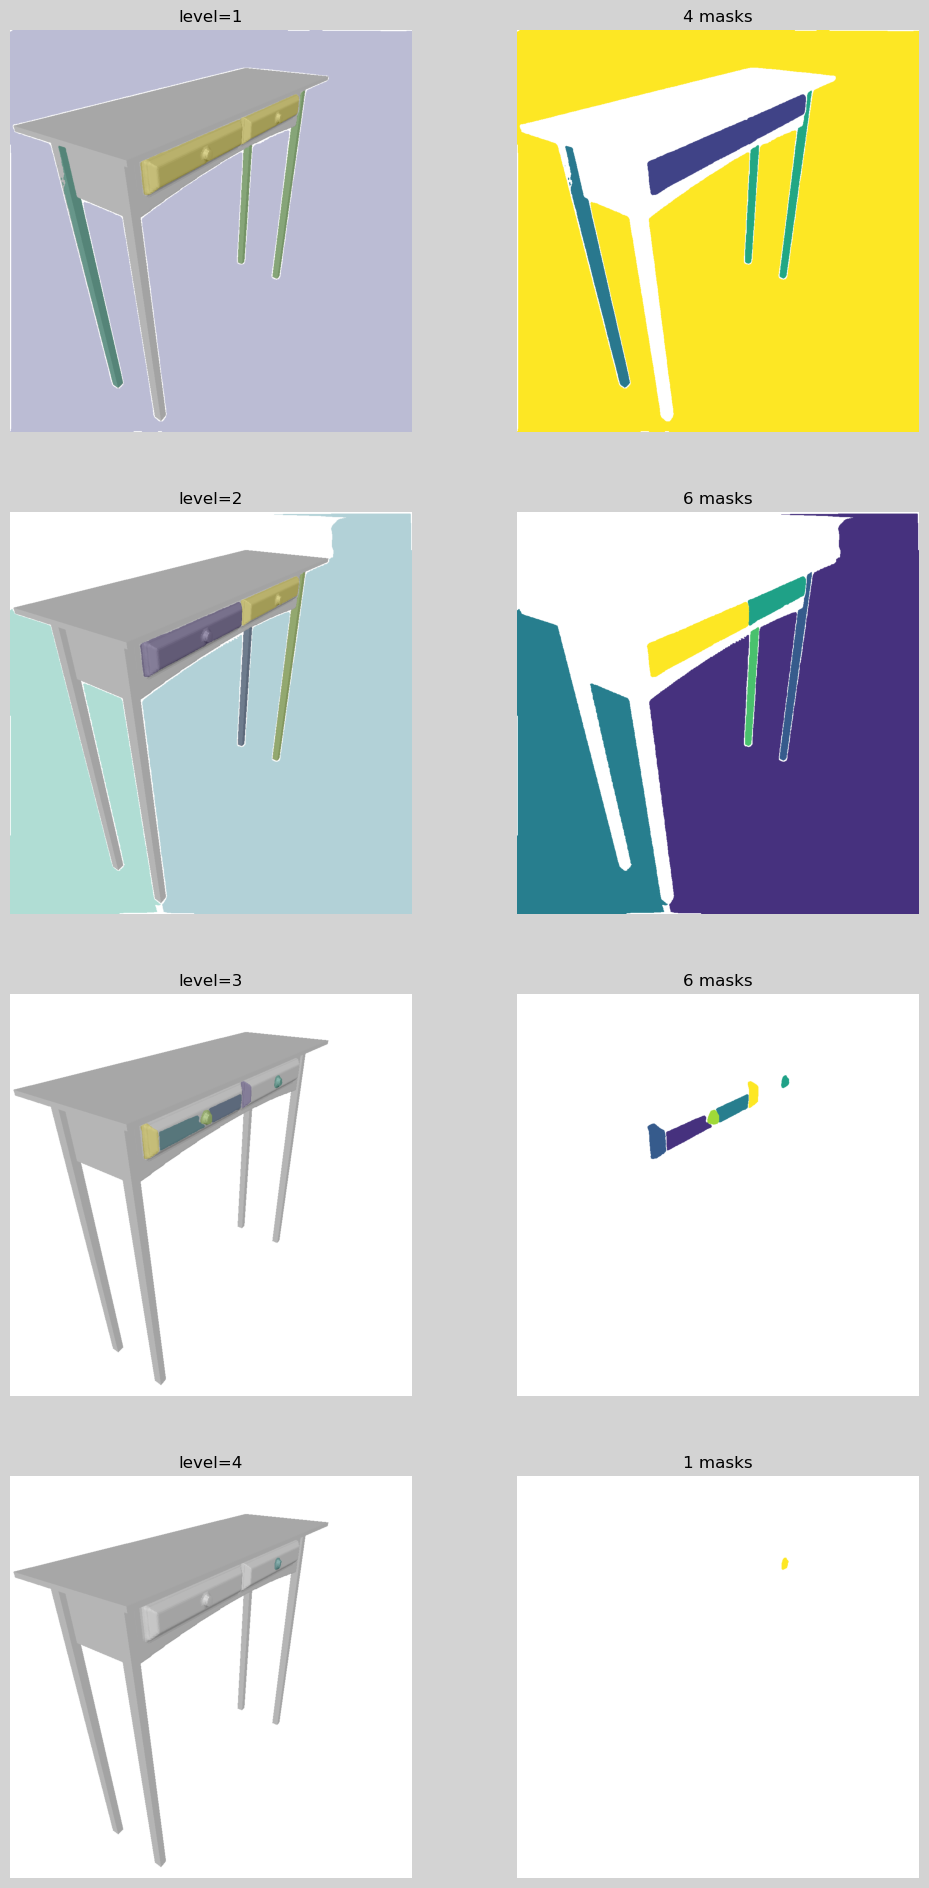

In [13]:
show_index = 8
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
show_all_levels(image, tree_data, facecolor='lightgray', width=6)

In [14]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(num_views)):
    if cache_dir.joinpath(f"view_{index:04d}.data").exists():
        continue
    tree_data = predictor.generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_iters=100,
        in_threshold=0.9,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 60021.52it/s]


In [15]:
tree3d = Tree3Dv2(mesh, device=device)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir)
Gv = tree3d.build_view_graph()
Gm = tree3d.build_graph(Gv)
X, autoencoder = tree3d.get_graph_attr(epochs=5000)
print(autoencoder)

[Tree3D] GPU: (4.966549396514893, 11.904052734375)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'masks': IntTensor[3, 1024, 1024], 'iou_preds': F16Tensor[6], 'area': LongTensor[6], 'parent': IntTensor[7], 'first': IntTensor[7], 'next': IntTensor[7], 'last': IntTensor[7], 'cnt': 6, 'num_samples': IntTensor[7], 'extra': {}}, 'tri_id': LongTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 4], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (0.8673553466796875, 11.904052734375)
[Tree3D] view_masks, view_infos[0]: F32Tensor[100, 30569], (LongTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1540 masks, max_num: 35
[Tree3D] GPU: (2.842339515686035, 11.904052734375)
[Tree3D] X epoch[   0], loss: recon= 0.710, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.202, lr=9.990e-04
[Tree3D] X epoch[ 200], loss: recon= 0.046, lr=9.960e-04
[Tree3D] X epoch[ 300], loss: recon= 0.035, lr=9.911e-04
[Tree3D] X epoch[ 400], loss: recon= 0.033, lr=9.842e-04
[Tree3D] X epoch[ 500], loss: recon= 0.031, l

In [16]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(
    in_channels=X.shape[1],
    hidden_channels=128,
    num_layers=2,
    out_channels=K,
    norm='BatchNorm'
).cuda()
print(gnn)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

GCN(256, 70, num_layers=2)
[Tree3D] GPU: (3.0076966285705566, 11.904052734375)
[Tree3D] GPU: (2.7639265060424805, 11.904052734375)
[Tree3D] GPU: (2.764371395111084, 11.904052734375)
[Tree3D] Epoch 100: loss=1.486905, match= 0.829, mm= 0.825
[Tree3D] Epoch 200: loss=1.329889, match= 0.706, mm= 0.743
[Tree3D] Epoch 300: loss=1.102529, match= 0.649, mm= 0.714
[Tree3D] Epoch 400: loss=1.144028, match= 0.624, mm= 0.691
[Tree3D] Epoch 500: loss=1.077227, match= 0.594, mm= 0.671
[Tree3D] Epoch 600: loss=1.338564, match= 0.582, mm= 0.657
[Tree3D] Epoch 700: loss=1.141926, match= 0.587, mm= 0.635
[Tree3D] Epoch 800: loss=2.000000, match= 0.557, mm= 0.617
[Tree3D] Epoch 900: loss=1.111231, match= 0.555, mm= 0.618
[Tree3D] Epoch 1000: loss=1.217342, match= 0.565, mm= 0.615
[Tree3D] Epoch 1100: loss=1.293443, match= 0.583, mm= 0.607
[Tree3D] Epoch 1200: loss=0.989132, match= 0.523, mm= 0.563
[Tree3D] Epoch 1300: loss=1.146894, match= 0.550, mm= 0.587
[Tree3D] Epoch 1400: loss=0.682925, match= 0.50

In [17]:
# if gnn is not None:
#     # gnn.reset_parameters()
#     tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)

[Tree3D] GPU: (3.007866382598877, 11.904052734375)
[Tree3D] GPU: (2.7661824226379395, 11.904052734375)
[Tree3D] GPU: (2.766627311706543, 11.904052734375)
[Tree3D] Epoch 100: loss=1.099871, match= 0.509, mm= 0.664
[Tree3D] Epoch 200: loss=1.230549, match= 0.504, mm= 0.649
[Tree3D] Epoch 300: loss=0.918638, match= 0.536, mm= 0.667
[Tree3D] Epoch 400: loss=0.966669, match= 0.499, mm= 0.640
[Tree3D] Epoch 500: loss=0.908065, match= 0.505, mm= 0.628
[Tree3D] Epoch 600: loss=1.142843, match= 0.481, mm= 0.609
[Tree3D] Epoch 700: loss=1.265215, match= 0.490, mm= 0.608
[Tree3D] Epoch 800: loss=0.799104, match= 0.512, mm= 0.619
[Tree3D] Epoch 900: loss=1.783077, match= 0.508, mm= 0.608
[Tree3D] Epoch 1000: loss=0.797523, match= 0.508, mm= 0.600
[Tree3D] Epoch 1100: loss=0.955004, match= 0.495, mm= 0.590
[Tree3D] Epoch 1200: loss=1.999994, match= 0.490, mm= 0.573
[Tree3D] Epoch 1300: loss=0.664259, match= 0.482, mm= 0.566
[Tree3D] Epoch 1400: loss=0.960339, match= 0.460, mm= 0.546
[Tree3D] Epoch 

2

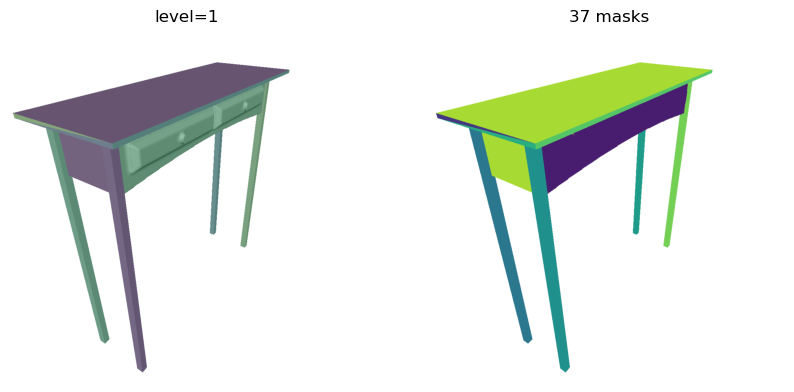

In [18]:
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])

In [19]:
tree3d.print_tree()
print(utils.show_shape(tree3d.masks))
# tree3d.save(cache_dir.joinpath('my.tree3dv2'))

0: Tree Root
├── 46
├── 45
├── 44
├── 43
├── 42
├── 41
├── 40
├── 39
├── 38
├── 37
├── 36
├── 35
├── 34
├── 33
├── 32
├── 31
├── 30
├── 29
├── 28
├── 27
├── 26
├── 25
├── 24
├── 23
├── 22
├── 21
├── 20
├── 19
├── 18
├── 17
├── 16
├── 15
├── 14
├── 13
├── 12
├── 11
├── 10
├── 9
├── 8
├── 7
├── 6
├── 5
├── 4
├── 3
├── 2
└── 1

BoolTensor[70, 30569]


In [20]:
utils.set_printoptions(linewidth=120)
metric = TreeSegmentMetric()
print(gt.cnt, type(gt).__name__)
metric.update(tree3d.to(device), gt_v2.to(device))
print(metric.summarize(), metric.gt_iou_sum / metric.cnt)
tree3d.print_tree()

16 Tree3D
[Tree] rerange nodes
[-1 -1 -1 -1 -1 14 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 15  2 -1 -1 -1 -1  5 10  8 -1 -1 -1 -1 -1 -1 -1 -1 11 -1
 -1  3  7 12 -1 -1  6]
[0.     0.     0.     0.     0.     0.6914 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.9344 0.8879 0.8245 0.     0.     0.     0.     0.7562 0.9167 0.7182 0.     0.     0.     0.     0.
 0.     0.     0.     0.5161 0.     0.     0.8163 0.8072 0.6318 0.     0.     0.6064]
[-1 -1 21 40 19 26 45 41 28 -1 27 37 42 -1  5 20]
[0.     0.     0.8245 0.8163 0.9344 0.7562 0.6064 0.8072 0.7182 0.     0.9167 0.5161 0.6318 0.     0.6914 0.8879]
0.29377635832755794 0.5691916942596436


0: Tree Root
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
├── 11
├── 12
├── 13
├── 14
├── 15
├── 16
├── 17
├── 18
├── 19
├── 20
├── 21
├── 22
├── 23
├── 24
├── 25
├── 26
├── 27
├── 28
├── 29
├── 30
├── 31
├── 32
├── 33
├── 34
├── 35
├── 36
├── 37
├── 38
├── 39
├── 40
├── 41
├── 42
├── 43
├── 44
├── 45
└── 46

In [21]:
# test new
# del tree3d_gt
tree3d_gt = Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.build_gt_segmentation(gt_v2, tri_ids)
Gv_ = tree3d_gt.build_view_graph()
Gm_ = tree3d_gt.build_graph(Gv_)
X_, autoencoder = tree3d_gt.get_graph_attr(epochs=5000)
print(autoencoder)
print(utils.show_shape(Gv_, Gm_, X_))

[Tree] reset
[Tree3D] view_masks, view_infos[0]: F32Tensor[100, 30569], (LongTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1082 masks, max_num: 16
[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.712, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.196, lr=9.990e-04
[Tree3D] X epoch[ 200], loss: recon= 0.053, lr=9.960e-04
[Tree3D] X epoch[ 300], loss: recon= 0.039, lr=9.911e-04
[Tree3D] X epoch[ 400], loss: recon= 0.033, lr=9.842e-04
[Tree3D] X epoch[ 500], loss: recon= 0.030, lr=9.755e-04
[Tree3D] X epoch[ 600], loss: recon= 0.031, lr=9.648e-04
[Tree3D] X epoch[ 700], loss: recon= 0.026, lr=9.523e-04
[Tree3D] X epoch[ 800], loss: recon= 0.024, lr=9.381e-04
[Tree3D] X epoch[ 900], loss: recon= 0.023, lr=9.221e-04
[Tree3D] X epoch[1000], loss: recon= 0.021, lr=9.044e-04
[Tree3D] X epoch[1100], loss: recon= 0.021, lr=8.852e-04
[Tree3D] X epoch[1200], loss: recon= 0.020, lr=8.644e-04
[Tree3D] X epoch[1300], loss: recon= 0.018, lr

view graph: torch.Size([100, 100]) edges: 2512


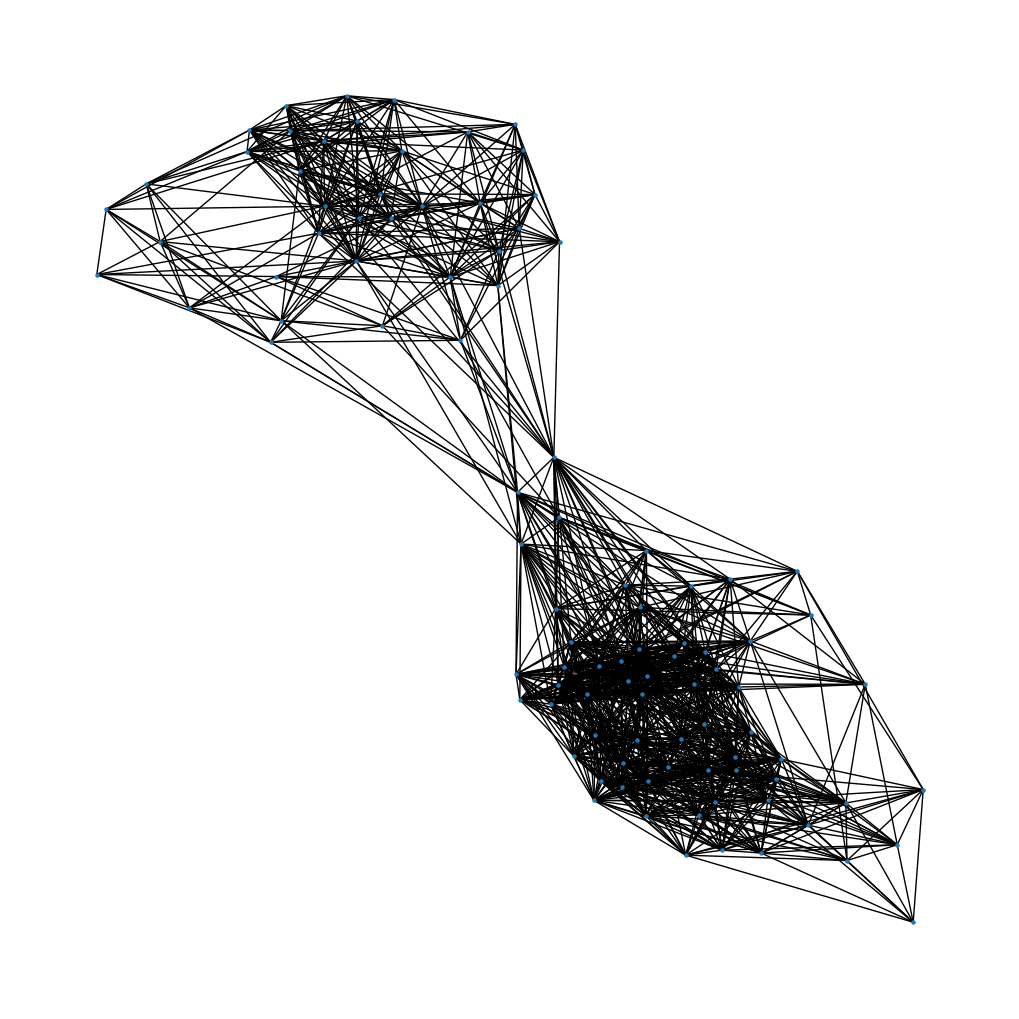

In [22]:
print('view graph:', Gv_.shape, 'edges:', Gv_.sum().item())

G_ = nx.Graph()
G_.add_nodes_from(range(Gv_.shape[0]))
for ab in torch.nonzero(Gv_):
    a, b = ab[0].item(), ab[1].item()
    if a < b:
        G_.add_edge(a, b)
plt.figure(figsize=(10, 10))
nx.draw(G_, node_size=5)
plt.show()


In [54]:
K = gt.cnt * 2
gnn = pyg.nn.GCN(
    in_channels=X_.shape[1],
    hidden_channels=128,
    num_layers=2,
    out_channels=K,
    norm='BatchNorm'
).cuda()
print(gnn)

tree3d_gt.run(epochs=5000, K=K, gnn=gnn, A=Gm_ * (Gm_ > 0.5), X=X_)
tree3d_gt.save(cache_dir.joinpath('gt_gnn.tree3dv2'))

GCN(256, 32, num_layers=2)
[Tree3D] GPU: (4.60745906829834, 11.904052734375)
[Tree3D] GPU: (4.501233100891113, 11.904052734375)
[Tree3D] GPU: (4.501740455627441, 11.904052734375)
[Tree3D] Epoch 100: loss=1.147421, match= 0.598, mm= 0.713
[Tree3D] Epoch 200: loss=1.082989, match= 0.514, mm= 0.639
[Tree3D] Epoch 300: loss=0.973113, match= 0.460, mm= 0.594
[Tree3D] Epoch 400: loss=1.201664, match= 0.456, mm= 0.566
[Tree3D] Epoch 500: loss=1.251205, match= 0.432, mm= 0.542
[Tree3D] Epoch 600: loss=1.091821, match= 0.412, mm= 0.527
[Tree3D] Epoch 700: loss=0.784145, match= 0.397, mm= 0.503
[Tree3D] Epoch 800: loss=0.769013, match= 0.400, mm= 0.475
[Tree3D] Epoch 900: loss=0.938176, match= 0.399, mm= 0.437
[Tree3D] Epoch 1000: loss=0.852248, match= 0.391, mm= 0.415
[Tree3D] Epoch 1100: loss=0.795010, match= 0.369, mm= 0.397
[Tree3D] Epoch 1200: loss=0.770709, match= 0.388, mm= 0.380
[Tree3D] Epoch 1300: loss=0.827971, match= 0.399, mm= 0.362
[Tree3D] Epoch 1400: loss=0.560920, match= 0.374, 

In [55]:
# tree3d_gt.save(cache_dir.joinpath('gt_gnn.tree3dv2'))
print(tree3d_gt.scores)

tensor([0.9626, 0.9088, 0.9044, 0.8993, 0.8980, 0.8863, 0.8782, 0.8332, 0.8302, 0.8301, 0.8297, 0.7957, 0.7392, 0.7313,
        0.7082, 0.6898, 0.6876, 0.6299, 0.6111, 0.5718, 0.5463, 0.5375, 0.5117, 0.5047, 0.4956, 0.4825, 0.4567, 0.4293,
        0.3468, 0.1772, 0.1584, 0.1575], device='cuda:0')


[Tree] rerange nodes


0: Tree Root
├── 1
├── 2
├── 3
├── 4
├── 5
├── 6
├── 7
├── 8
├── 9
├── 10
├── 11
├── 12
├── 13
├── 14
├── 15
├── 16
├── 17
├── 18
├── 19
├── 20
├── 21
├── 22
├── 23
└── 24

[Tree] rerange nodes
[Tree] rerange nodes
[-1 -1 -1 -1  0 -1  6 -1 -1 -1 -1  4 -1  7 11  2 -1  8 13  9 -1  5  1 10]
[0.     0.     0.     0.     0.9915 0.     0.8565 0.     0.     0.     0.     0.8166 0.     0.8455 0.617  0.8145 0.
 0.8628 0.5854 0.9461 0.     0.7597 0.9158 0.5941]
[ 4 22 15 -1 11 21  6 13 17 19 23 14 -1 18 -1 -1]
[0.9915 0.9158 0.8145 0.     0.8166 0.7597 0.8565 0.8455 0.8628 0.9461 0.5941 0.617  0.     0.5854 0.     0.    ]
0.48027653694152833 0.6003456711769104


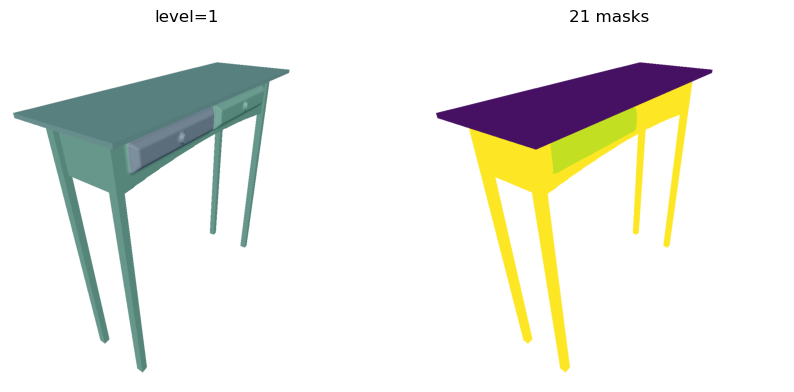

In [56]:
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt_v2.to(device))
print(metric.summarize(), metric.gt_iou_sum / metric.cnt)

In [53]:
@torch.enable_grad()
def run(Adj: Tensor, Attr: Tensor, t: Tree3Dv2, epochs=5000):
    gnn = pyg.nn.GCN(
        in_channels=X_.shape[1],
        hidden_channels=128,
        num_layers=2,
        out_channels=128,
        norm='BatchNorm'
    ).cuda()

    opt = torch.optim.Adam(gnn.parameters(), lr=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, 1e-6)

    edges = torch.nonzero(Adj).T
    edge_weights = Adj[edges[0], edges[1]]
    print(utils.show_shape(edges, edge_weights))

    for epoch in range(epochs):
        opt.zero_grad()
        view_index = torch.randint(0, t.N_view, (1,)).item()
        view_mask = t.view_infos[view_index][0]
        print('view_mask', utils.show_shape(view_mask))
        features = gnn(Attr, edges, edge_weight=edge_weights)
        print(utils.show_shape(features))
        start_index, end_index = t.view_range[view_index]
        for u in range(start_index, end_index):
            linked = edges[1, edges[0] == u]
            scores = F.relu(torch.mv(features[linked], features[u]))  # shape: [Nu]
            linked = F.pad(linked, (0, 1), value=u)
            scores = F.pad(scores, (0, 1), value=1)  # TODO: 权重参数化
            mask_u = scores @ t.face_masks[linked]  # shape: [Nu, F]
            print(utils.show_shape(scores, linked, t.view_masks[t.view_indices[linked]], mask_u))
            mask_u = mask_u / (scores @ t.view_masks[t.view_indices[linked]]).clamp_min(1e-7)
            mask_u = mask_u[view_mask]
            print((mask_u - t.face_masks[u, view_mask]).abs().sum())
            diff = F.mse_loss(mask_u, t.face_masks[u, view_mask])  # to FocalLoss
            print(utils.show_shape(mask_u), diff)
            # print(u, utils.show_shape(linked, scores), linked, scores)
        opt.step()
        lr_scheduler.step()
        break


run(Gm_ * (Gm_ >= 0.5), X, tree3d_gt)

LongTensor[2, 27174], F32Tensor[27174]
view_mask LongTensor[11629]
F32Tensor[1540, 128]
F32Tensor[28], LongTensor[28], F32Tensor[28, 30569], F32Tensor[30569]
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
F32Tensor[11629] tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
F32Tensor[30], LongTensor[30], F32Tensor[30, 30569], F32Tensor[30569]
tensor(306.6496, device='cuda:0', grad_fn=<SumBackward0>)
F32Tensor[11629] tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)
F32Tensor[26], LongTensor[26], F32Tensor[26, 30569], F32Tensor[30569]
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
F32Tensor[11629] tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
F32Tensor[28], LongTensor[28], F32Tensor[28, 30569], F32Tensor[30569]
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
F32Tensor[11629] tensor(0., device='cuda:0', grad_fn=<MseLossBackward0>)
F32Tensor[28], LongTensor[28], F32Tensor[28, 30569], F32Tensor[30569]
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
